# Overview

Simple exploration of admissions data using pymc3

### Imports

In [1]:
%matplotlib inline
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import theano
import arviz as az
import seaborn as sns
from scipy.special import expit as logistic

import warnings

import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output


%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
df = pd.read_csv("uas.csv")
df = df.iloc[:, 1:]
df.head()

,university,province,subject,tier,录取人数,年份,admission_score,最低录取位次,admission_ranking
0,北京大学,江苏,文科,本科一批,22,2017,405,34,28
1,北京大学,北京,文科,本科一批,-1,2017,660,100,92
2,北京大学,重庆,文科,本科一批,16,2017,646,30,24
3,北京大学,广东,文科,本科一批,22,2017,640,28,24
4,北京大学,广西,文科,本科一批,17,2017,658,19,17


In [3]:
df.columns = ["university", "province", "subject", "college_tier", "n_students_admitted", "year", "admission_score", "lowest_accepted_ranking", "score_rank"]
df.head()

,university,province,subject,college_tier,n_students_admitted,year,admission_score,lowest_accepted_ranking,score_rank
0,北京大学,江苏,文科,本科一批,22,2017,405,34,28
1,北京大学,北京,文科,本科一批,-1,2017,660,100,92
2,北京大学,重庆,文科,本科一批,16,2017,646,30,24
3,北京大学,广东,文科,本科一批,22,2017,640,28,24
4,北京大学,广西,文科,本科一批,17,2017,658,19,17


In [4]:
df.shape

(187783, 9)

In [5]:
df["max_possible_score"] = np.where(df.province == "海南", 900, 750)
df["admission_score_norm"] = df.admission_score / df.max_possible_score
df["exp_admission_score"] = 1 / (1 + np.power(np.exp(df.admission_score_norm), -1))
df["n_students_admitted"] = np.where(df["n_students_admitted"] == -1, np.nan, df["n_students_admitted"])
df["lowest_accepted_ranking"] = np.where(df["lowest_accepted_ranking"] == -1, np.nan, df["lowest_accepted_ranking"])

In [6]:
df[df["lowest_accepted_ranking"].isna()]

,university,province,subject,college_tier,n_students_admitted,year,admission_score,lowest_accepted_ranking,score_rank,max_possible_score,admission_score_norm,exp_admission_score
38,北京大学,四川,文科,本科一批,24.0,2015,638,NaN,1,750,0.850667,0.700707
39,北京大学,江苏,文科,本科一批,18.0,2015,400,NaN,7,750,0.533333,0.630260
40,北京大学,内蒙古,文科,本科一批,6.0,2015,630,NaN,1,750,0.840000,0.698465
135,清华大学,山东,文科,本科一批,3.0,2015,671,NaN,1,750,0.894667,0.709852


## Some weird observations

In [7]:
# remove known wrong data
df = df[df.n_students_admitted < 50000]

In [8]:
# Are these wrong or outliers?
df[df.n_students_admitted > 10000]

,university,province,subject,college_tier,n_students_admitted,year,admission_score,lowest_accepted_ranking,score_rank,max_possible_score,admission_score_norm,exp_admission_score
29880,中国石油大学（华东）,山东,理科,本科一批,11118.0,2016,612,19589.0,19053,750,0.816000,0.693387
45664,贵州大学明德学院,江西,文科,本科二批,35066.0,2016,451,35066.0,34664,750,0.601333,0.645961
64370,湖南科技学院,湖南,理科,本科二批,16511.0,2018,466,88271.0,87694,750,0.621333,0.650522
70695,北京科技大学天津学院,重庆,文科,本科二批,26883.0,2018,462,26883.0,26531,750,0.616000,0.649308


In [9]:
# Some observations where lowest accepted ranking is higher than the score_rank? Do colleges take people below cutoff?
# there are -1
df[df.lowest_accepted_ranking < df.score_rank]

,university,province,subject,college_tier,n_students_admitted,year,admission_score,lowest_accepted_ranking,score_rank,max_possible_score,admission_score_norm,exp_admission_score
46,中国人民大学,江苏,理科,本科一批,30.0,2017,392,968.0,1084,750,0.522667,0.627771
48,中国人民大学,河南,文科,本科一批,46.0,2017,632,146.0,147,750,0.842667,0.699027
49,中国人民大学,天津,文科,本科一批,20.0,2017,639,58.0,59,750,0.852000,0.700987
136,北京交通大学,广西,理科,本科一批,95.0,2017,557,5364.0,5374,750,0.742667,0.677579
147,北京交通大学,内蒙古,理科,本科一批,102.0,2017,578,4014.0,4037,750,0.770667,0.683665
...,...,...,...,...,...,...,...,...,...,...,...,...
185654,九江学院,广西,理科,专科批,16.0,2018,315,131691.0,131809,750,0.420000,0.603483
185818,贵州警察学院,广西,文科,本科二批,3.0,2018,471,25375.0,25397,750,0.628000,0.652036
185819,贵州警察学院,广西,文科,专科批,5.0,2018,333,76881.0,76915,750,0.444000,0.609212
185823,贵州警察学院,广西,理科,专科批,5.0,2018,281,147425.0,147496,750,0.374667,0.592586


In [10]:
df[df.lowest_accepted_ranking == -1]

,university,province,subject,college_tier,n_students_admitted,year,admission_score,lowest_accepted_ranking,score_rank,max_possible_score,admission_score_norm,exp_admission_score


## Plots

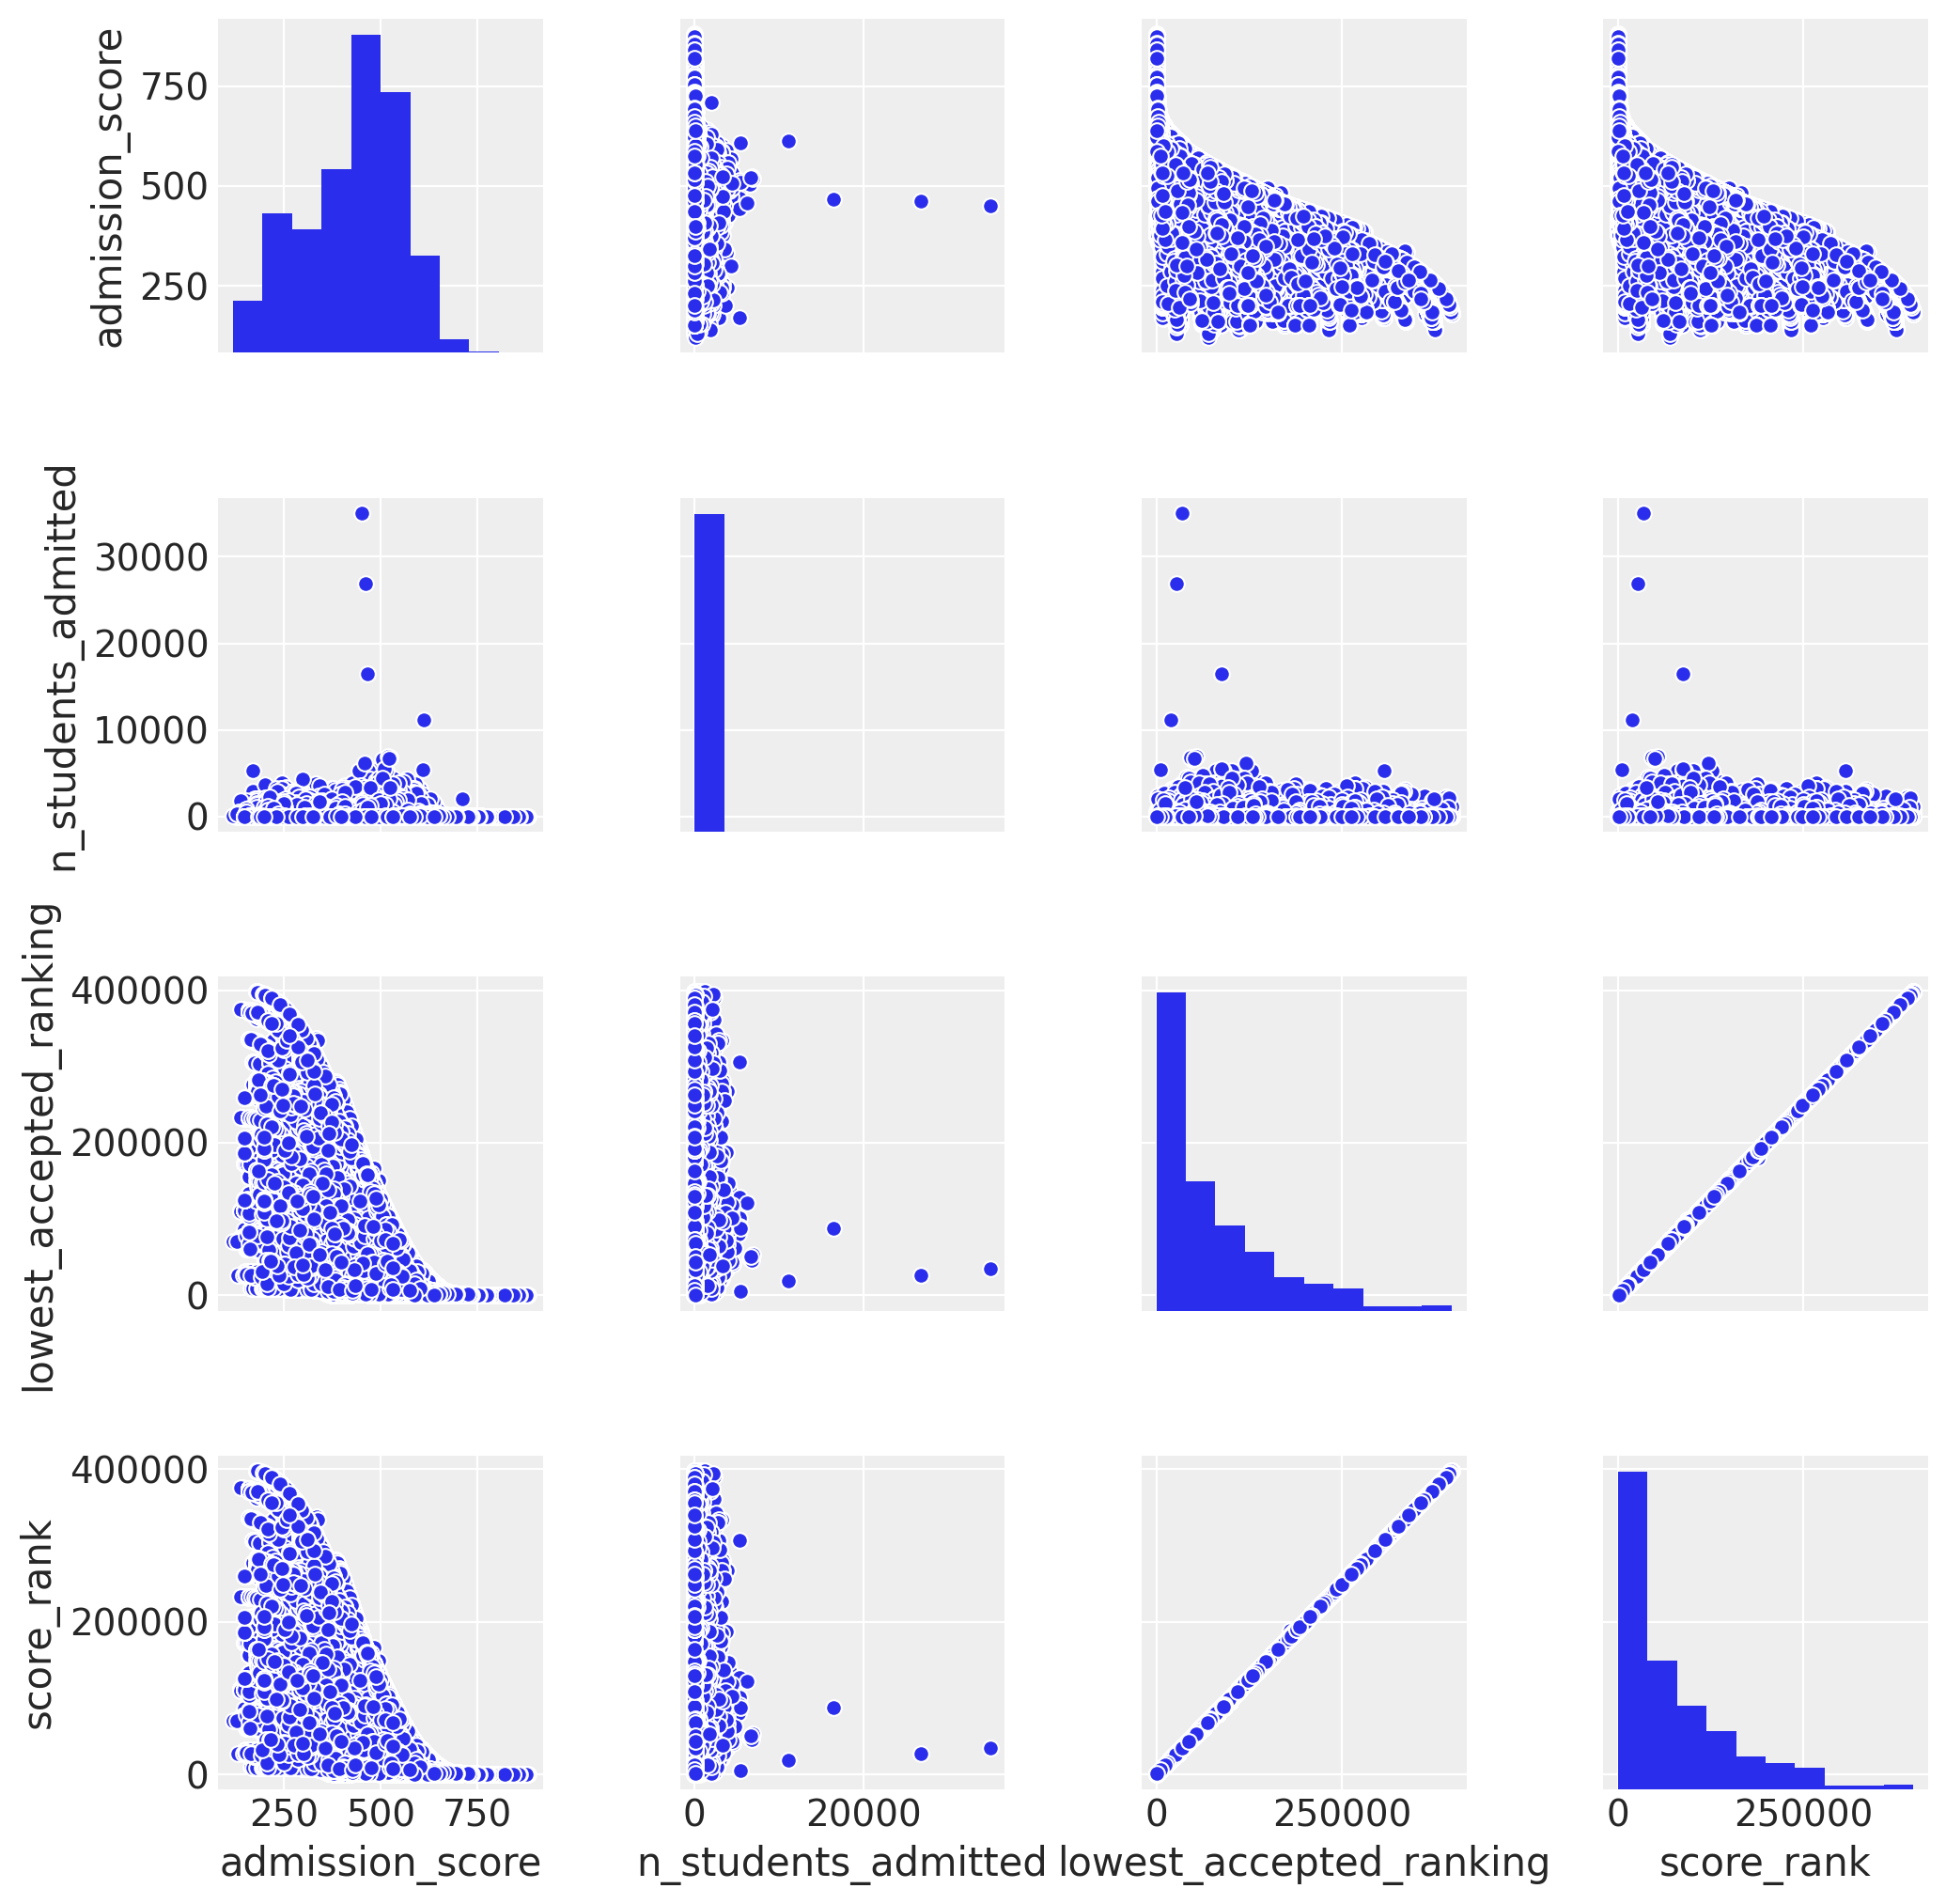

In [159]:
sns.pairplot(df[["admission_score", "n_students_admitted", "lowest_accepted_ranking","score_rank"]]);

In [16]:
# Build App
cols = ["n_students_admitted","admission_score","lowest_accepted_ranking","score_rank","max_possible_score","admission_score_norm", "exp_admission_score"]
app = JupyterDash(__name__)
app.layout = html.Div([
    html.Label(["Province"]),
    dcc.Dropdown(
        id='province', clearable=False,
        value=df['province'][0], options=[
            {'label': c, 'value': c}
            for c in df['province'].unique().tolist()
        ]),
    html.Label(["X Axis"]),
    dcc.Dropdown(
        id='x_column', clearable=False,
        value=cols[0], options=[
            {'label': c, 'value': c}
            for c in cols
        ]),
    html.Label(["Y Axis"]),
    dcc.Dropdown(
        id='y_column', clearable=False,
        value=cols[0], options=[
            {'label': c, 'value': c}
            for c in cols
        ]),
    dcc.Graph(id='graph')
    
])
# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("province", "value"), Input("y_column", "value"), Input("x_column", "value")]
)
def update_figure(province, y, x):
    temp = df.query("province == @province")
    fig = px.scatter(temp, x, y, color="year", facet_col="subject", title=province, height=500)
    return fig
# Run app and display result inline in the notebook
app.run_server(mode='inline')

1. There seem to be some provinces where data is not widely available. This will cause an issue in estimation as there is not historical data.
2. Some provinces/ subjects have many college tiers while others do not. Data is also sparse for certain tiers
3. Although the lowest_accepted_rank and score_rank and similar, we can safely assume that colleges will take people who are above the cutoff. It would be good to include this information into a model
4. With every increasing year, the number of spots available seems to be increasing. this is driving the cut off score to reduce - especially for the lower ranking universities

## Data Information

Some information for context:

Many aspects of the data are defined per province:  
- The score rank
- Minimum rank for admission into university
- The final admission score and rank is, therefore, affected by the province
    
Colleges are defined into quality Tiers - which is defined nationally

In order to predict the admission score, we need to incorporate information about two separate heirarchies of groups:
1. Tier and college
2. Province and its interaction with rank, minimum rank

Some notes:

Score and and Admission scores are both bounded variables. One way to predict the admission score would be to model the admission score as a logistic function.

## Data prep

In [164]:
train = df.query("year != 2019").reset_index()
test = df.query("year == 2019").reset_index()

In [165]:
train.university = pd.Categorical(train.university)
train.subject = pd.Categorical(train.subject)
train.college_tier = pd.Categorical(train.college_tier)
train.province = pd.Categorical(train.province)
train.year = pd.Categorical(train.year)

## Model 1: Basic averaging (No Pooling)

A simple assumption would be to assume that each province, university, subject and college_tier is independent. We define No pooling effects (separate intercepts) for each of these groups to find the score. The intercepts denote the average contribution of each group to the score (given all else is zero)

Mathematically,

$$
\begin{align}
\text{admission_score}_i &= p_i * \text{max_possible_score} \\
\text{logit($p_i$)} &= \alpha_{province[i]} + \alpha_{university[i]} + \alpha_{subject[i]} + \alpha_{college\_tier[i]} \\
\alpha_{province[i]} &\sim Normal(0, 200) \\
\alpha_{university[i]} &\sim Normal(0, 200) \\
\alpha_{subject[i]} &\sim Normal(0, 200) \\
\alpha_{college\_tier[i]} &\sim Normal(0, 200) \\
\end{align}
$$

In [97]:
with pm.Model() as m1_avg:
    a_province = pm.Normal("a_province", mu=0, sd=200, shape=df.province.nunique())
    a_university = pm.Normal("a_university", mu=0, sd=200, shape=df.university.nunique())
    a_subject = pm.Normal("a_subject", mu=0, sd=200, shape=df.subject.nunique())
    a_tier = pm.Normal("a_tier", mu=0, sd=200, shape=df.college_tier.nunique())
    p = pm.Deterministic("p", a_province[train.province.cat.codes] + a_university[train.university.cat.codes] + a_subject[train.subject.cat.codes] + a_tier[train.college_tier.cat.codes])
    admission_norm = pm.Bernoulli("add_score_norm", logit_p=p, observed=train.admission_score_norm)
    admission_s = pm.Deterministic("add_score", admission_norm * train.max_possible_score)
    trace_m1_avg = pm.sample(500, tune=500)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_tier, a_subject, a_university, a_province]
Sampling 2 chains, 0 divergences:  23%|██▎       | 465/2000 [1:10:13<3:51:49,  9.06s/draws] 


ValueError: Not enough samples to build a trace.

## Model 2: Partial Pooling

In the above model, we derive no extra information from data of other groups. That is, even though we have information for different colleges, we do no use them to inform predictions for other colleges. For example, if we know the average admission score for a low grade college, it would be nice to use this average score as a baseline for a new college of a similar grade. We do this via partial pooling.

Mathematically,

$$
\begin{align}
\text{admission_score}_i &= p_i * \text{max_possible_score} \\
\text{logit($p_i$)} &= \gamma_{province} + \gamma_{university} + \gamma_{subject} + \gamma_{college\_tier} + \alpha_{province[i]} + \alpha_{university[i]} + \alpha_{subject[i]} + \alpha_{college\_tier[i]} \\
\alpha_{province[i]} &\sim Normal(0, \sigma_{province}) \\
\alpha_{university[i]} &\sim Normal(0, \sigma_{university}) \\
\alpha_{subject[i]} &\sim Normal(0, \sigma_{subject}) \\
\alpha_{college\_tier[i]} &\sim Normal(0, \sigma_{college\_tier}) \\
\gamma_{province} &\sim Normal(0, 100) \\
\gamma_{university} &\sim Normal(0, 100) \\
\gamma_{subject} &\sim Normal(0, 100) \\
\gamma_{college\_tier} &\sim Normal(0, 100) \\
\sigma_{province} &\sim Exp(1) \\
\sigma_{university} &\sim Exp(1) \\
\sigma_{subject} &\sim Exp(1) \\
\sigma_{college\_tier} &\sim Exp(1) \\
\end{align}
$$

In [166]:
with pm.Model() as m2_pp:
    sigma_province = pm.HalfCauchy("sigma_province", 1)
    sigma_university = pm.HalfCauchy("sigma_university", 1)
    sigma_subject = pm.HalfCauchy("sigma_subject", 1)
    sigma_tier = pm.HalfCauchy("sigma_tier", 1)
    g_province = pm.Normal("gamma_province", mu=0, sd=sigma_province)
    g_university = pm.Normal("gamma_university", mu=0, sd=sigma_university)
    g_subject = pm.Normal("gamma_subject", mu=0, sd=sigma_subject)
    g_tier = pm.Normal("gamma_tier", mu=0, sd=sigma_tier)
    a_province = pm.Normal("a_province", mu=0, sd=200, shape=df.province.nunique())
    a_university = pm.Normal("a_university", mu=0, sd=200, shape=df.university.nunique())
    a_subject = pm.Normal("a_subject", mu=0, sd=200, shape=df.subject.nunique())
    a_tier = pm.Normal("a_tier", mu=0, sd=200, shape=df.college_tier.nunique())
    alpha = a_province[train.province.cat.codes] + a_university[train.university.cat.codes] + a_subject[train.subject.cat.codes] + a_tier[train.college_tier.cat.codes]
    gamma = g_province + g_university + g_subject + g_tier
    p = pm.Deterministic("p", gamma + alpha)
    admission_norm = pm.Bernoulli("add_score_norm", logit_p=p, observed=train.admission_score_norm)
    admission_s = pm.Deterministic("add_score", admission_norm * train.max_possible_score)
    trace_m2_pp = pm.sample(500, tune=500)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

## Model 3: Partial Pooling with covariates

I use the above model but add year, score_rank and 
Mathematically,

$$
\begin{align}
\text{admission_score}_i &= p_i * \text{max_possible_score} \\
\text{logit($p_i$)} &= \gamma_{province} + \gamma_{university} + \gamma_{subject} + \gamma_{college\_tier} + \alpha_{province[i]} + \alpha_{university[i]} + \alpha_{subject[i]} + \alpha_{college\_tier[i]} + \beta_1 * score\_rank + \beta_2 * year + \beta_3 * lowest\_accepted\_ranking \\
\alpha_{province[i]} &\sim Normal(0, \sigma_{province}) \\
\alpha_{university[i]} &\sim Normal(0, \sigma_{university}) \\
\alpha_{subject[i]} &\sim Normal(0, \sigma_{subject}) \\
\alpha_{college\_tier[i]} &\sim Normal(0, \sigma_{college\_tier}) \\
\gamma_{province} &\sim Normal(0, 100) \\
\gamma_{university} &\sim Normal(0, 100) \\
\gamma_{subject} &\sim Normal(0, 100) \\
\gamma_{college\_tier} &\sim Normal(0, 100) \\
\sigma_{province} &\sim Exp(1) \\
\sigma_{university} &\sim Exp(1) \\
\sigma_{subject} &\sim Exp(1) \\
\sigma_{college\_tier} &\sim Exp(1) \\
\beta_1 &\sim Normal(0,100) \\
\beta_2 &\sim Normal(0,100) \\
\beta_3 &\sim Normal(0,100) \\
\end{align}
$$

In [167]:
with pm.Model() as m3_pp:
    betas = pm.Normal("beta", mu=0, sd=100, shape=3)
    sigma_province = pm.HalfCauchy("sigma_province", 1)
    sigma_university = pm.HalfCauchy("sigma_university", 1)
    sigma_subject = pm.HalfCauchy("sigma_subject", 1)
    sigma_tier = pm.HalfCauchy("sigma_tier", 1)
    g_province = pm.Normal("gamma_province", mu=0, sd=sigma_province)
    g_university = pm.Normal("gamma_university", mu=0, sd=sigma_university)
    g_subject = pm.Normal("gamma_subject", mu=0, sd=sigma_subject)
    g_tier = pm.Normal("gamma_tier", mu=0, sd=sigma_tier)
    a_province = pm.Normal("a_province", mu=0, sd=200, shape=df.province.nunique())
    a_university = pm.Normal("a_university", mu=0, sd=200, shape=df.university.nunique())
    a_subject = pm.Normal("a_subject", mu=0, sd=200, shape=df.subject.nunique())
    a_tier = pm.Normal("a_tier", mu=0, sd=200, shape=df.college_tier.nunique())
    alpha = a_province[train.province.cat.codes] + a_university[train.university.cat.codes] + a_subject[train.subject.cat.codes] + a_tier[train.college_tier.cat.codes]
    gamma = g_province + g_university + g_subject + g_tier
    X = betas[0] * train.score_rank + betas[1] * train.year + betas[2] * train.lowest_accepted_ranking
    p = pm.Deterministic("p", gamma + alpha + X)
    admission_norm = pm.Bernoulli("add_score_norm", logit_p=p, observed=train.admission_score_norm)
    admission_s = pm.Deterministic("add_score", admission_norm * train.max_possible_score)
    trace_m3_pp = pm.sample(500, tune=500)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_tier, a_subject, a_university, a_province, gamma_tier, gamma_subject, gamma_university, gamma_province, sigma_tier, sigma_subject, sigma_university, sigma_province, beta]
Sampling 2 chains, 0 divergences:   5%|▍         | 96/2000 [02:13<44:01,  1.39s/draws]  


ValueError: Not enough samples to build a trace.

$$
f(x \mid \mu, s) =     \frac{\exp\left(-\frac{x - \mu}{s}\right)}{s \left(1 + \exp\left(-\frac{x - \mu}{s}\right)\right)^2}
$$

In [223]:
x=df.groupby(["province","college_tier", "university", "year", "subject"]).score_rank.transform('count')
df[x > 1]

,university,province,subject,college_tier,n_students_admitted,year,admission_score,lowest_accepted_ranking,score_rank,max_possible_score,admission_score_norm,exp_admission_score
16076,上海师范大学天华学院,湖南,文科,本科三批,-1,2017,465,36968,36722,750,0.620000,0.650219
16456,上海电机学院,内蒙古,文科,本科二批B类,10,2016,442,11321,11177,750,0.589333,0.643212
22142,安徽理工大学,重庆,理科,本科一批,7,2016,532,31677,31236,750,0.709333,0.670254
22171,安徽理工大学,重庆,理科,本科一批,71,2016,502,45307,44828,750,0.669333,0.661354
22287,安徽农业大学,重庆,文科,本科一批,3,2016,536,7146,6978,750,0.714667,0.671432
...,...,...,...,...,...,...,...,...,...,...,...,...
187732,西安财经大学,甘肃,理科,本科二批,-1,2019,487,28578,28578,750,0.649333,0.656860
187733,西安财经大学,宁夏,文科,本科二批,13,2019,541,2564,2564,750,0.721333,0.672901
187737,西安财经大学,宁夏,理科,本科二批,24,2019,462,10745,10745,750,0.616000,0.649308
187741,西安财经大学,青海,文科,本科二批,11,2019,496,1569,1569,750,0.661333,0.659560


,n_students_admitted,admission_score,lowest_accepted_ranking,score_rank,max_possible_score,admission_score_norm,exp_admission_score
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...
187778,1,1,1,1,1,1,1
187779,1,1,1,1,1,1,1
187780,1,1,1,1,1,1,1
187781,1,1,1,1,1,1,1


In [204]:
x=df[["university", "college_tier"]].drop_duplicates().groupby("university").count()
x[x > 1]

,college_tier
university,
七台河职业学院,2.0
三亚中瑞酒店管理职业学院,NaN
三亚城市职业学院,NaN
三亚学院,4.0
三亚理工职业学院,2.0
...,...
齐齐哈尔大学,3.0
齐齐哈尔工程学院,7.0
齐齐哈尔理工职业学院,NaN


In [201]:
df[(df.university == "深圳大学") & (df.year == 2016) & (df.subject == "理科") & (df.province == "云南")]

,university,province,subject,college_tier,n_students_admitted,year,admission_score,lowest_accepted_ranking,score_rank,max_possible_score,admission_score_norm,exp_admission_score
37494,深圳大学,云南,理科,本科一批,26,2016,598,6423,6254,750,0.797333,0.689404
37495,深圳大学,云南,理科,本科一批,-1,2016,598,6422,6254,750,0.797333,0.689404
